# 이 코드는 앞으로 데이터들을 다룰 때 일일이 코드를 쳐야하는 불편함을 없애기 위해 만들어진 코드다. 즉 재사용에 목적이 있다. 최대한 필요한 지표들을 모두 담고자 하였다. 그리고 편의를 위해 AutoARIMA 함수를 사용했다.
# 원래 목표는 사용자가 할 일은 하나도 없이 자동으로 해주는 것인데 아직까지는 어려운 것 같다.

### 사용한 패키지들

In [2]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa import stattools


### 데이터 처리해주는 단계
파일의 이름, Datetime, data 는 사용자가 수정해줘야 함

In [3]:
df = pd.read_excel("Covid19.xlsx")

target_data = 'Daily'

df.index = pd.to_datetime(df['Date'])

df = df.dropna(subset=[target_data])

data = df[target_data]

### 데이터 시각화
데이터가 올바르게 로드되었는지 확인

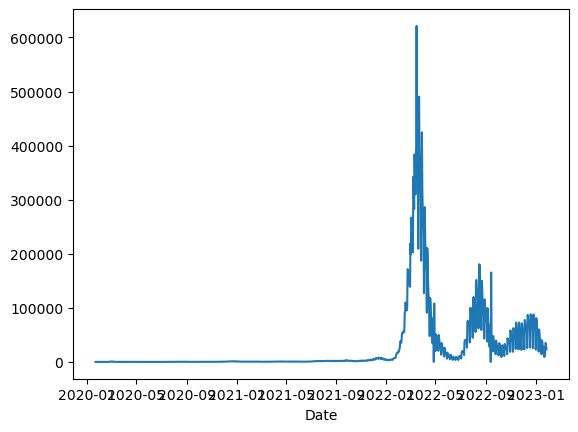

In [8]:
plt.plot(data)
plt.xlabel('Date')
plt.show()

### 계절성이 있는지 판단하는 단계

acf, pacf를 보고 계절성이 있는지 없는지만 판단하면 됨.

C:\Anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


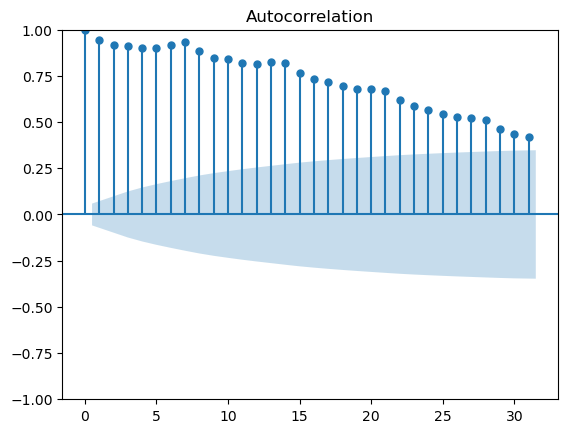

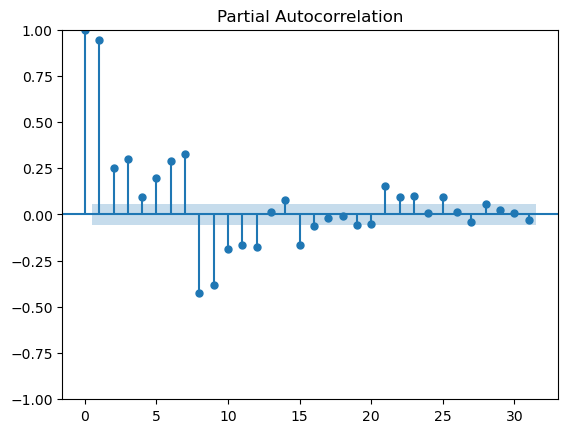

In [9]:
plot_acf(data)
plot_pacf(data)

plt.show()

### Train set, Test set 으로 분리
모델이 정확하게 추정할 수 있는지 확인하는 용도

In [10]:
train_size = int(len(data)*0.9)

train_data, test_data = train_test_split(data, train_size=train_size, shuffle=False)

print(test_data)
print(train_data)


Date
2022-10-09     8981
2022-10-10    15476
2022-10-11    30503
2022-10-12    26928
2022-10-13    23562
              ...  
2023-01-23    12262
2023-01-24    19538
2023-01-25    35096
2023-01-26    31711
2023-01-27    23367
Name: Daily, Length: 111, dtype: int64
Date
2020-01-22        1
2020-01-23        0
2020-01-24        1
2020-01-25        0
2020-01-26        1
              ...  
2022-10-04    34710
2022-10-05    28603
2022-10-06    22259
2022-10-07    19379
2022-10-08    17654
Name: Daily, Length: 991, dtype: int64


### autoARIMA 함수 사용 

위에서 계절성이 있는 거 같으면 sesonal에서 True, 없는 거 같으면 False로 변경해주면 됨.

In [11]:
model = auto_arima(train_data, seasonal=True, suppress_warnings=True, error_action="ignore", stepwise=True,
                   trace=True, random_state=42)

print(model.order, model.seasonal_order)

model_order = model.order
model_seasonal_order = model.seasonal_order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22648.759, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22577.884, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22481.226, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22646.760, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22456.702, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=22436.498, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=22486.609, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=22438.172, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=22427.162, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=22443.764, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=22317.805, Time=0.35 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=22429.977, Time=0.24 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=22237.507, Time=1.03 sec
 ARIMA(3,1,3)(0,0,0)[0] i

### 예측 시각화

statsmodel package를 사용하기 위해 모델의 계수를 가져옴

C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


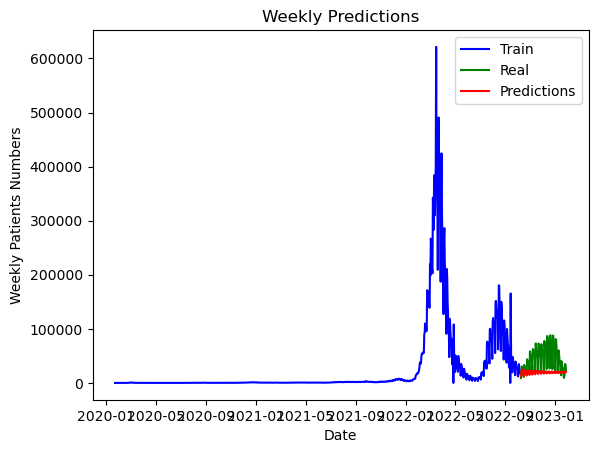

In [12]:
model = SARIMAX(train_data, order=model_order, seaonal_order=model_seasonal_order)
model_fit = model.fit()

predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')


plt.plot(train_data, label = 'Train', color = 'blue')
plt.plot(test_data, label = 'Real', color = 'green')
plt.plot(predictions, label='Predictions', color = 'red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Weekly Patients Numbers')
plt.title('Weekly Predictions')
plt.show()

### 전체 데이터와 ARMIA 모델 시각화

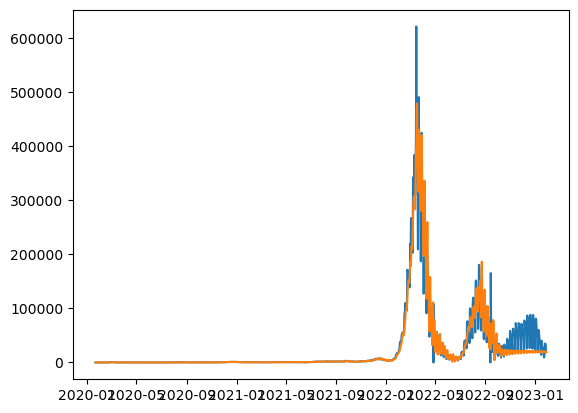

In [13]:
plt.plot(data)
plt.plot(model_fit.predict(start=0, end=len(data), typ='levels'))

plt.show()

### 잔차를 확인하는 작업

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


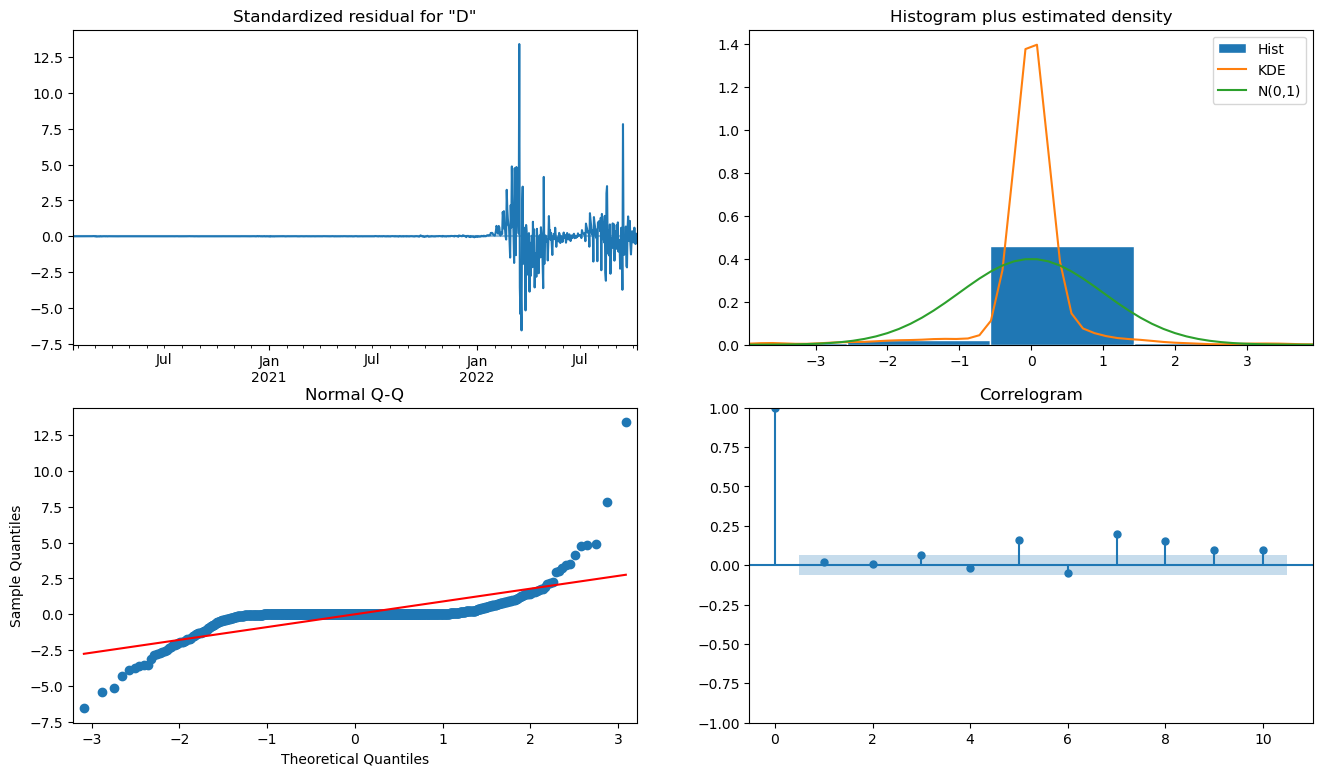

In [14]:
model.fit().plot_diagnostics(figsize = (16,9))
plt.show()

### 신뢰구간 안에 들어오는지 확인

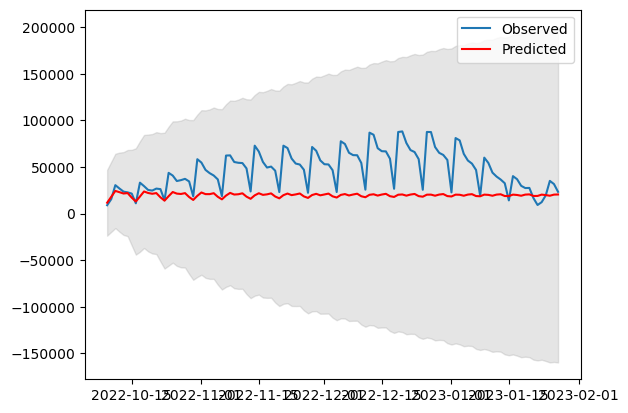

In [15]:
pred = model_fit.get_prediction(start=test_data.index[0], end=test_data.index[-1], dynamic=False)
pred_conf = pred.conf_int()

plt.plot(test_data, label='Observed')
plt.plot(pred.predicted_mean, 'r', label='Predicted')
plt.fill_between(pred_conf.index, pred_conf.iloc[:,0], pred_conf.iloc[:,1], color='gray',alpha=0.2)
plt.legend()
plt.show()